## Finetuning BETO

In this notebook, we will check what happens if we fine tune using MLM on the TASS tweets

In [2]:
import os
from glob import glob
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"


In [3]:
import torch
from transformers import BertForMaskedLM, BertTokenizerFast

model_name = 'dccuchile/bert-base-spanish-wwm-cased'

device = "cuda" if torch.cuda.is_available() else "cpu"

model = BertForMaskedLM.from_pretrained(model_name, return_dict=True, num_labels=3)
model = model.to(device)
tokenizer = BertTokenizerFast.from_pretrained(model_name)
tokenizer.model_max_length = 128

In [4]:
from glob import glob

tweet_files = glob("../data/tweets/spanish/*.txt")

tweet_files = tweet_files[:100]
limit = int(0.93 * len(tweet_files))
train_files = tweet_files[:limit]
dev_files = tweet_files[limit:]

In [5]:
%%time
from datasets import load_dataset


train_dataset, test_dataset = load_dataset("text", data_files={"train": train_files, "test": dev_files}, split=["train", "test"])


Using custom data configuration default


Dataset text downloaded and prepared to /home/jmperez/.cache/huggingface/datasets/text/default-6cc9eaa74e5a23f7/0.0.0/52cefbb2b82b015d4253f1aeb1e6ee5591124a6491e834acfe1751f765925155. Subsequent calls will reuse this data.
CPU times: user 356 ms, sys: 40 ms, total: 396 ms
Wall time: 1.6 s


In [6]:
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

batch_size = 48

eval_batch_size = 16

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
#dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
#test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)


What about lengths of tweets?

(array([7.1752e+04, 4.0037e+04, 1.1234e+04, 4.4810e+03, 2.9270e+03,
        2.0020e+03, 4.9000e+02, 6.9000e+01, 1.4000e+01, 3.1000e+01]),
 array([  2. ,  14.6,  27.2,  39.8,  52.4,  65. ,  77.6,  90.2, 102.8,
        115.4, 128. ]),
 <BarContainer object of 10 artists>)

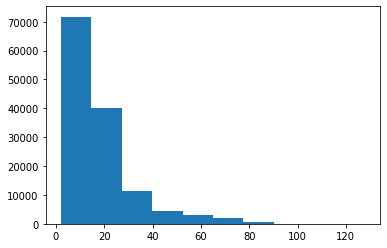

In [7]:
import matplotlib.pyplot as plt
lens = [sum(t["attention_mask"]) for t in train_dataset]

plt.hist(lens)

128 should do the trick

In [8]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [9]:
from transformers import Trainer, TrainingArguments

model_name = "TwiBETO-general"

model_path = f"./{model_name}"

training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    num_train_epochs=30,
    evaluation_strategy="steps",
    eval_steps=1500,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    save_steps=2000,
    logging_steps=50,
    do_eval= True,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    prediction_loss_only=True,
)

/home/jmperez/.local/share/virtualenvs/pysent-oyXQVI9B/lib/python3.8/site-packages/transformers/trainer.py:277: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  warnings.warn(


In [10]:
%%time
trainer.train()

/home/jmperez/.local/share/virtualenvs/pysent-oyXQVI9B/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
1500,2.496255,3.228600
3000,2.345537,3.203470
4500,2.237148,3.189625


/home/jmperez/.local/share/virtualenvs/pysent-oyXQVI9B/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jmperez/.local/share/virtualenvs/pysent-oyXQVI9B/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

In [11]:
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('./TwiBETO-general/tokenizer_config.json',
 './TwiBETO-general/special_tokens_map.json',
 './TwiBETO-general/vocab.txt',
 './TwiBETO-general/added_tokens.json')

## Checking mask


In [1]:
from transformers import pipeline

model_name = 'dccuchile/bert-base-spanish-wwm-cased'

fill_mask_beto = pipeline(
    "fill-mask",
    model=model_name,
    tokenizer=model_name
)

fill_mask_twibeto = pipeline(
    "fill-mask",
    model="../models/TwiBETO-general/",
    tokenizer=model_name
)

Some weights of BertModel were not initialized from the model checkpoint at ../models/TwiBETO-general/checkpoint-2000/ and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
phrase = "la capital de Rusia es [MASK]"

targets = None
fill_mask_twibeto(phrase, targets=targets)

[{'sequence': '[CLS] la capital de Rusia es Rusia [SEP]',
  'score': 0.07089567929506302,
  'token': 5298,
  'token_str': 'Rusia'},
 {'sequence': '[CLS] la capital de Rusia es Moscú [SEP]',
  'score': 0.04152743145823479,
  'token': 11487,
  'token_str': 'Moscú'},
 {'sequence': '[CLS] la capital de Rusia es Madrid [SEP]',
  'score': 0.021272020414471626,
  'token': 5233,
  'token_str': 'Madrid'},
 {'sequence': '[CLS] la capital de Rusia es usuario [SEP]',
  'score': 0.019806960597634315,
  'token': 9127,
  'token_str': 'usuario'},
 {'sequence': '[CLS] la capital de Rusia es España [SEP]',
  'score': 0.01951727829873562,
  'token': 3229,
  'token_str': 'España'}]

In [57]:
fill_mask_beto(phrase, targets=targets)

[{'sequence': '[CLS] la capital de España es : [SEP]',
  'score': 0.3050116002559662,
  'token': 1181,
  'token_str': ':'},
 {'sequence': '[CLS] la capital de España es Madrid [SEP]',
  'score': 0.13494569063186646,
  'token': 5233,
  'token_str': 'Madrid'},
 {'sequence': '[CLS] la capital de España es. [SEP]',
  'score': 0.12530945241451263,
  'token': 1009,
  'token_str': '.'},
 {'sequence': '[CLS] la capital de España es [UNK] [SEP]',
  'score': 0.05696418881416321,
  'token': 3,
  'token_str': '[UNK]'},
 {'sequence': '[CLS] la capital de España es Sevilla [SEP]',
  'score': 0.04788172245025635,
  'token': 12332,
  'token_str': 'Sevilla'}]

In [ ]:
fill_mask_beto?